# MA999 - Agent based modelling 4 - Daisyworld

## MathSys CDT 2023

### Lecturer: Paolo Turrini 
(thanks to Colm Connaughton and Stas Zhydkov) 

## The Gaia Hypothesis

The interactions between the biological and non-biological components of the Earth system form a self-regulating complex system which acts to maintain the conditions favourable to life on the planet.

Watson & Lovelock (1983)

Criticised by evolutionary biologists since it seemed to imply large scale cooperation between organisms counter to prevailing theories of natural selection

## Daisyworld model

The Daisyworld model is a minimal model of a planetary ecology demonstrating that thermoregulation can emerge from *competitive* interaction between species.

### Model ingredients:

* Daisyworld is home to two species of daisies, black daisies and white daisies, that are identical in all respects other than their color.
* Daisies compete for space on Daisywork by spreading to occupy available bare ground.
* Daisies' rate of reproduction, $\beta(T)$, is a function of temperature with a single maximum at $T_\text{opt}$.
* Daisies' rate of death is constant, $\gamma$.
* Daisies interact with the environment through their *albedo*:
    * Black daisies absorb sunlight and increase the local temperature above that of bare ground.
    * White daisies reflect sunlight and decrease the local temperature below that of bare ground.

## Mathematical model of Daisyworld

The orginal model of Watson and Lovelock was a mean-field model that did not explicitly account for space. The dependent variables are the *proportions* of the surface area occupied by the white and black daisies:
* $A_w(t)$ : proportion of the surface occupied by white daisies.
* $A_b(t)$ : proportion of the surface occupied by black daisies.

We denote by $A_0(t)$ the proportion of the surface that is bare. Clearly we have the constraint:
$$ A_w(t) + A_b(t) + A_0(t) = 1$$

In [ ]:
%pwd

In [ ]:
%cd .

In [ ]:
import mesa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sys
sys.path.append('./code')
import importlib
import DW
importlib.reload(DW)

### Modelling the growth rate of daisies

We need a model of the growth rate of the daisies. A parabolic function is the simplest:

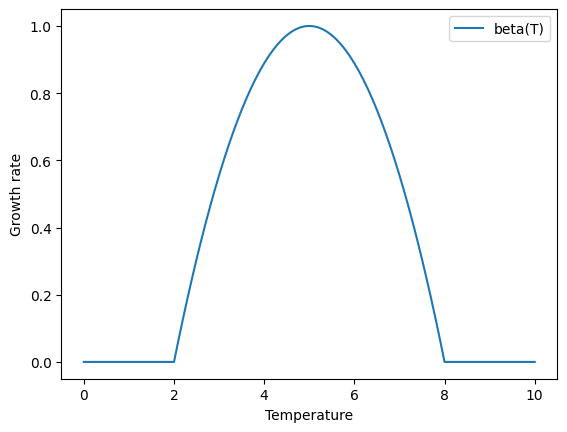

In [4]:
# Define the growth rate function
def growth_rate(x, xm, xr):
    return np.maximum(-(x - xm + xr) * (x - xm - xr) / xr**2, 0.0)

# Generate data for plotting
X = np.arange(0, 10.1, 0.1)
xm = 5
xr = 3
Y = growth_rate(X, xm, xr)

# Create the plot
plt.figure()
plt.plot(X, Y, label="beta(T)")
plt.ylabel("Growth rate")
plt.xlabel("Temperature")
plt.legend()
plt.show()

### Modelling the population dynamics of the daisies

We can use standard mean-field population dynamics equations to model the competitive dynamics of the daisies.

$$ \frac{d A_w}{d t} = \beta(T_w)\, A_w\, A_0 - \gamma\,A_w $$
$$ \frac{d A_b}{d t} = \beta(T_b)\, A_b\, A_0 - \gamma\,A_b $$

with $A_0(t) = 1 - A_w(t) - A_b(t)$.

In these equations, $T_w$ and $T_b$ are the local temperatures of patches of white and black daisies respectively.

### Modelling the average global temperature of Daisyworld

The key to modelling the temperature is to capture incorporate concept of albedo. The albedo of a surface is the proportion of incoming radiation that it reflects. 
* An albedo of 1 means all incoming radiation is reflected (resulting in a cooler surface). 
* An albedo of 0 means all incoming radiation is absorbed (resulting in a hotter surface).

If $F$ is the incoming solar radiation flux, the average temperature of Daisyworld, $T_\text{av}$, is given by the [Stefan-Boltzmann law](https://www.britannica.com/science/Stefan-Boltzmann-law):
$$ \sigma T_\text{av}^4 = F\,(1-\alpha)$$
where $\alpha$ is the average albedo of the surface and $\sigma$ is a constant of proportionality.

If $\alpha_w$, $\alpha_b$ and $\alpha_0$ are the albedos of white, black and bare patches respectively (conventionally taken to be 3/4, 1/4 and 1/2), then the average albedo is
$$ \alpha(t) = \alpha_w\, A_w(t) + \alpha_b\,A_b(t) + \alpha_0\,A_0(t)$$.

### Modelling the local temperatures

However, daisies don't experience the global temperature, they experience local modified temperatures that depend on the difference between the local and average albedo:

$$ T_w^4 = T_\text{av}^4 + q\,(\alpha - \alpha_w) $$
$$ T_b^4 = T_\text{av}^4 + q\,(\alpha - \alpha_b) $$
$$ T_0^4 = T_\text{av}^4 + q\,(\alpha - \alpha_0). $$

Here $q$ is a phenomenological modelling parameter (akin to a diffusion coefficient) controlling the strength of local variations in temperature. 

Later, we will do away with the need to make this assumption in an agent-based variation of the Daisyworld model which incorporates spatial structure directly.

Note that since we have already written $T_\text{av}$ and $\alpha$ in terms of $A_w$ and $A_b$, we now have a closed set of differential equations which we can solve.

## Reminder: Solving differential equations in SciPy:

Python's `scipy` library has a well-developed system for solving systems of differential equations called `scipy.integrate.solve_ivp`. In its basic form, it is very simple to use. Here is an example that solves the Lorentz equations:

### Step 1: define the RHS of the system of equations

* ```t``` is the time variable (for non-autonomous systems)
* ```u``` are the dependent variables for (as a vector)
* ```p``` is a list of parameters that need to be passed in

In [5]:
from scipy.integrate import solve_ivp

# First we define the RHS:
def lorenz(t, u, sigma, rho, beta):
    x, y, z = u
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
    return [dx, dy, dz]

### Step 2: define the problem

This entails
* specifying the initial condition, ```u0```.
* specifying the time interval in which to solve the equations, ```t_span```
* providing values for the parameters, ```p```
* calling `solve_ivp` which takes the RHS function, `t_span`, `u0`, and `args` for the parameters.

In [6]:
u0 = [1.0,0.0,0.0]
t_span = (0.0,100.0)
p = (10.0, 28.0, 8/3)
sol = solve_ivp(lorenz, t_span, u0, args=p, dense_output=True)

### Step 3: plot and analyse the solution.

In [7]:
print(sol)

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  3.568e-05 ...  1.000e+02  1.000e+02]
        y: [[ 1.000e+00  9.996e-01 ...  3.828e+00  4.019e+00]
            [ 0.000e+00  9.988e-04 ...  7.840e+00  8.226e+00]
            [ 0.000e+00  1.781e-08 ...  4.736e+00  4.823e+00]]
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x000001AE86987B60>
 t_events: None
 y_events: None
     nfev: 9470
     njev: 0
      nlu: 0


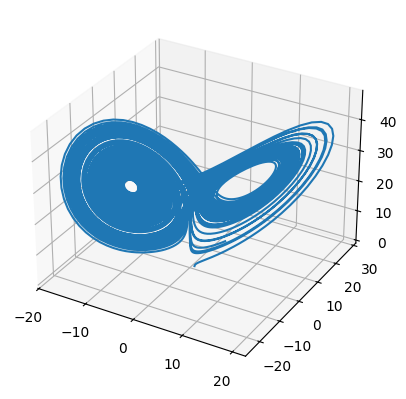

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
t = np.linspace(t_span[0], t_span[1], 10000)
x, y, z = sol.sol(t)
ax.plot(x, y, z)
plt.show()

## Solving the Daisyworld equations

First we set up the parameters

In [9]:
# Define parameters
Topt = 5
Delta_T = 6
gamma = 0.1
alpha_w = 0.75
alpha_b = 0.25
alpha_0 = 0.5
sigma = (1.0 - alpha_0) / (Topt**4.0)
q = 0.25

beta = lambda T: max(-(T - Topt + Delta_T/2.0) * (T - Topt - Delta_T/2.0) / (Delta_T/2.0)**2, 0.0)
F = lambda t: 1.0

In [10]:
p = (beta, gamma, alpha_w, alpha_b, alpha_0, sigma, q, F)
u0 = [0.08, 0.12]
t_span = (0.0, 100.0)

Here's a function that defines the right-hand side of the equations:

In [11]:
def daisyworld_ode(t, u, p):
    # Get the dependent variables
    Aw, Ab = u
    # Get the parameters
    beta, gamma, alpha_w, alpha_b, alpha_0, sigma, q, F = p
    # Proportion of bare ground:
    A0 = 1.0 - Aw - Ab
    # Work out average albedo and temperature
    alpha = alpha_w * Aw + alpha_b * Ab + alpha_0 * A0
    Tav = (F(t) * (1.0 - alpha) / sigma)**0.25
    # Work out local temperatures:
    Tw = (Tav**4.0 + q * (alpha - alpha_w))**0.25
    Tb = (Tav**4.0 + q * (alpha - alpha_b))**0.25
    # Construct the RHS of the population dynamics equations
    dAw_dt = beta(Tw) * Aw * A0 - gamma * Aw
    dAb_dt = beta(Tb) * Ab * A0 - gamma * Ab
    return [dAw_dt, dAb_dt]

Now we can integrate the equations as we did for the Lorentz model:

In [12]:
sol = solve_ivp(daisyworld_ode, t_span, u0, args=(p,), dense_output=True)

In [13]:
print(sol)

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.076e-01 ...  9.794e+01  1.000e+02]
        y: [[ 8.000e-02  8.619e-02 ...  3.598e-01  3.599e-01]
            [ 1.200e-01  1.293e-01 ...  5.396e-01  5.399e-01]]
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x000001AE86BF65D0>
 t_events: None
 y_events: None
     nfev: 218
     njev: 0
      nlu: 0


Here's how to extract the individual components of the solution for analysis

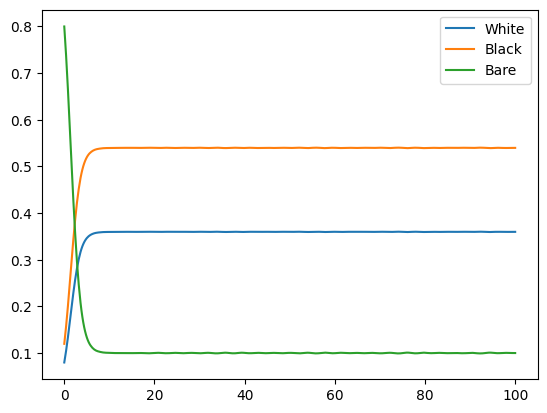

In [14]:
t = np.linspace(t_span[0], t_span[1], 500)
Aw, Ab = sol.sol(t)
A0 = 1.0 - Aw - Ab

plt.figure()
plt.plot(t, Aw, label="White")
plt.plot(t, Ab, label="Black")
plt.plot(t, A0, label="Bare")
plt.legend()
plt.show()

Here's the average temperature

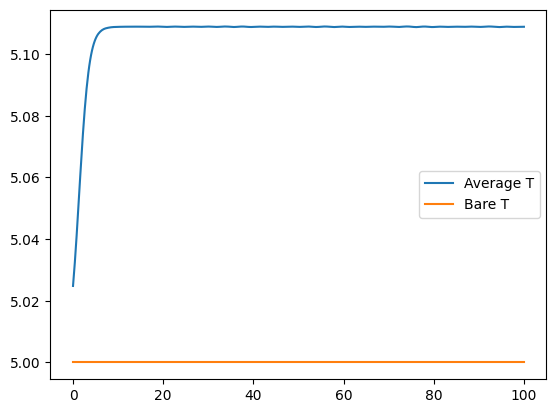

In [15]:
alpha = alpha_w * Aw + alpha_b * Ab + alpha_0 * A0
Tav = (np.array(list(map(F, t))) * (1.0 - alpha) / sigma)**0.25
Tbare = (np.array(list(map(F, t))) * (1.0 - alpha_0) / sigma)**0.25

plt.figure()
plt.plot(t, Tav, label="Average T")
plt.plot(t, Tbare, label="Bare T")
plt.legend()
plt.show()

## Agent based version of the Daisyworld model

The way in which local temperature variation is handled in the mean field Daisyworld model is not entirely transparent. 

An ABM version of Daisyworld will be modeled as a 2-D grid.

Agents correspond to patches associated with grid points. Each patch has its own colour (with corresponding albedo) and local temperature.

In an ABM each patch can absorb a fixed fraction of solar irradiance at each time step to assign it a temperature. Local temperatures can then be calculated in a natural way by averaging over the temperatures of neighbouring cells.

### Descriptive specification of the model dynamics

At each step:
1. each white/black patch picks a random neighbouring patch. If that patch is bare, a new white/black patch is created there with probability $p_\beta(T_\text{local})$. 
2. each white/black patch dies with probability $p_\gamma$.
3. each patch updates its local temperature to be $\alpha F$ where $F$ is the solar irradiance and $\alpha$ is the appropriate albedo value.
4. after all agents have updated the local temperatures of all agents are recalculated by performing a weighted average of the local temperatures.

It is natural to encode steps 1 - 3 in the `agent.step()` method and step 4 in the `model.step()` method.

### Agent definition

Let's get started.

Here's the basic definition of an agent:

In [16]:
class DaisyPatch(mesa.Agent):
    """An agent representing a patch of ground in the Daisyworld model."""
    def __init__(self, model, colour, temperature):
        super().__init__(model)
        self.colour = colour  # 1: white, 2: black, 3: empty
        self.temperature = temperature

### Model properties

As with our transportation example, we pass the parameters to the model object:

In [17]:
class Daisyworld(mesa.Model):
    """The Daisyworld model."""
    def __init__(self, width=DW.SIZE_DFLT, height=DW.SIZE_DFLT,
                 t_opt=DW.T_OPT_DFLT, t_range=DW.T_RANGE_DFLT,
                 p_death=DW.P_DEATH_DFLT, p_growth=DW.P_GROWTH_DFLT,
                 delta=DW.DELTA_DFLT, albedo=DW.ALBEDO_DFLT, flux_func=DW.F_DFLT, seed=None):

        super().__init__(seed=seed)
        self.grid = mesa.space.SingleGrid(width, height, torus=True)

        self.t_opt = t_opt
        self.t_range = t_range
        self.p_death = p_death
        self.p_growth = p_growth
        self.delta = delta
        self.albedo = albedo
        self.flux = flux_func
        self.step_num = 0

        # Growth rate function
        self.growth_rate = lambda T: max(-(T - self.t_opt + self.t_range) * (T - self.t_opt - self.t_range) / (self.t_range**2), 0.0)

        # Initial temperature of a "bare" planet
        t_init = self.flux(1) * (1 - self.albedo[2]) # Absorbed energy from empty patch albedo

        # Create agents (patches)
        DaisyPatch.create_agents(self, width * height, colour=3, temperature=t_init)
        for i in range(width * height):
            x = i % width
            y = i // width
            # All patches are initially empty
            self.grid.move_agent(self.agents[i], (x, y))

        self.datacollector = mesa.DataCollector(
            agent_reporters={"colour": "colour", "temperature": "temperature"}
        )

### Agent step function

Here is the agent step function:

In [18]:
class DaisyPatch(DaisyPatch):
    def step(self):
        """Agent's step action."""
        if self.colour == 3:  # If empty
            # With low probability, an empty patch can grow daisies
            if self.random.random() <= self.model.p_growth:
                self.colour = self.random.choice([1, 2])
        else:  # If occupied by a daisy
            # An occupied patch can attempt to reproduce
            neighbors = self.model.grid.get_neighbors(self.pos, moore=True)
            if neighbors:
                neighbor = self.random.choice(neighbors)
                if neighbor.colour == 3:  # Reproduce to an empty patch
                    growth_prob = self.model.growth_rate(self.temperature)
                    if self.random.random() <= growth_prob:
                        neighbor.colour = self.colour

            # An occupied patch can die
            if self.random.random() <= self.model.p_death:
                self.colour = 3

Note that we allow "spontaneous regrowth" with low probability to avoid the absorbing state (no daisies).

### Model step function

The model step function needs to calculate the local temperatures



In [19]:
class Daisyworld(Daisyworld):
    def step(self):
        """Model's step action."""
        self.agents.shuffle_do("step")

        # Calculate absorbed energy proportions
        absorbed_energy = [1.0 - x for x in self.albedo]

        # Calculate local temperatures
        current_flux = self.flux(self.step_num)

        # Store new temperatures to apply them all at once
        new_temperatures = {}

        for agent in self.agents:
            t1 = absorbed_energy[agent.colour - 1] * current_flux

            neighbors = self.grid.get_neighbors(agent.pos, moore=True)
            if neighbors:
                t2 = sum(absorbed_energy[n.colour - 1] * current_flux for n in neighbors) / len(neighbors)
            else:
                t2 = 0.0

            # Weighted sum for new local temperature
            new_temp = (1.0 - self.delta) * t1 + self.delta * t2
            new_temperatures[agent.unique_id] = new_temp

        # Update all agent temperatures
        for agent in self.agents:
            agent.temperature = new_temperatures[agent.unique_id]

        self.step_num += 1
        self.datacollector.collect(self)

### Model initialisation

In [20]:
model = Daisyworld()

### Running the model and gathering data

Let's just gather all agent states at each step rather than trying to do fancy data aggregation on the fly.

In [21]:
n_steps = 50
for _ in range(n_steps):
    model.step()

data = model.datacollector.get_agent_vars_dataframe()
print(data.head(10))

              colour  temperature
Step AgentID                     
1    1             3    32.500000
     2             3    31.992188
     3             1    20.312500
     4             3    31.992188
     5             3    32.500000
     6             3    32.500000
     7             3    32.500000
     8             3    32.500000
     9             3    32.500000
     10            3    32.500000


In [22]:
print(data.index.names)
print(data.columns)
print(data.loc[1].loc[625])
print(len(data.loc[1]))

['Step', 'AgentID']
Index(['colour', 'temperature'], dtype='object')
colour          3.000000
temperature    31.992188
Name: 625, dtype: float64
625


### Analysing the results

To visualise the simulation results, we can use `matplotlib` to build plots directly from the `data` DataFrame generated by the model.

The `matplotlib.animation` is very useful to create movies showing how the model evolves in time:

In [23]:
from matplotlib.animation import FuncAnimation

size = DW.SIZE_DFLT
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlim(0, size)
ax.set_ylim(0, size)
ax.set_aspect('equal')

scatter = ax.scatter([], [], s=100)

def update(frame):
    frame_data = data.loc[frame+1]
    colors = ['lightgrey' if c == 1 else 'black' if c == 2 else 'brown' for c in frame_data['colour']]
    positions = [(x % size, x // size) for x in range(size**2)]
    scatter.set_offsets(positions)
    scatter.set_color(colors)
    ax.set_title(f'Step {frame}')
    return scatter,

anim = FuncAnimation(fig, update, frames=range(n_steps), blit=True)
plt.close()

### Running the movie

The results can be viewed in a Jupyter notebook as follows:

In [25]:
from IPython.display import HTML
HTML(anim.to_jshtml())

### Calculate the populations of white and black daisies and the temperature

This requires a bit of post=processing on ```data```

In [26]:
# Extract some aggregated quantities from the simulation
# Mean temperature of daisyworld as a function of step
gdf = data.groupby('Step')
df_T = gdf['temperature'].mean().reset_index().rename(columns={'temperature': 'T_average'})

colour_counts = data.groupby(['Step', 'colour']).size().unstack(fill_value=0)
total_patches = model.grid.width * model.grid.height

### Create the plot

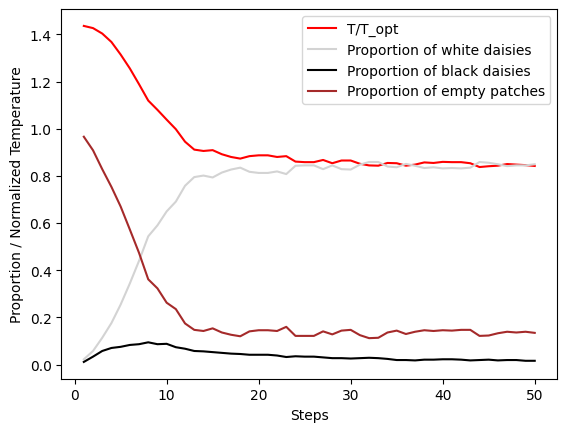

In [27]:
fig, ax = plt.subplots()

ax.plot(df_T['Step'], df_T['T_average'] / model.t_opt, label="T/T_opt", color="red")

if 1 in colour_counts.columns:
    ax.plot(colour_counts.index, colour_counts[1] / total_patches, label="Proportion of white daisies", color="lightgrey")
if 2 in colour_counts.columns:
    ax.plot(colour_counts.index, colour_counts[2] / total_patches, label="Proportion of black daisies", color="black")
if 3 in colour_counts.columns:
    ax.plot(colour_counts.index, colour_counts[3] / total_patches, label="Proportion of empty patches", color="brown")

ax.set_xlabel("Steps")
ax.set_ylabel("Proportion / Normalized Temperature")
ax.legend()
plt.show()

## The end

Hopefully you now know the basics of how to build, visualise and analyse ABMs in Python with Mesa. Do let me know if you ever use any of this for your own research!

## Useful links
* SciPy `solve_ivp` documentation : https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html

## References

[Watson, Andrew J., and James E. Lovelock. "Biological homeostasis of the global environment: the parable of Daisyworld." Tellus B: Chemical and Physical Meteorology 35, no. 4 (1983): 284-289.](https://www.tandfonline.com/doi/pdf/10.3402/tellusb.v35i4.14616)

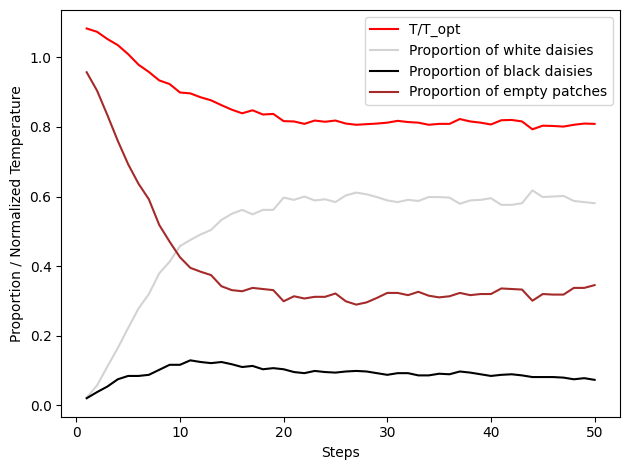

In [28]:
# Change the solar flux to see what happens
T_opt = 22.5
T_range = 10.0
F2 = lambda step: (T_opt + T_range) * 1.5
data, p = DW.run_daisyworld(50, flux_func=F2)
plt.show()